In [3]:
# Dependencies and setup
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import torch as th
import os
import cv2
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

import time

import shutil

import os

from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/Shareddrives/ME_592/HW3/Felipe/Data'

Mounted at /content/drive


In [4]:
# Comment this entire code block if the results should not be reproducible
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)
  
# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [5]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
robot_log_training = pd.read_csv(os.path.join(root, 'Training', 'robot_log.csv'), index_col = 'Path')
robot_log_test     = pd.read_csv(os.path.join(root, 'Test', 'robot_log.csv'), index_col = 'Path')

n_training_samples = len(robot_log_training) 
n_val_samples = len(robot_log_test)

print(f'Training n = {n_training_samples}')
print(f'Test n = {n_val_samples}')

Training n = 9914
Test n = 2504


In [ ]:
# Begin loading in images in IMG folder
# Keep them in a dict with filename as key

# robot_log.index = robot_log['Path']/

'''
Classification into bins
SteerAngle: -, 0, +
Throttle: -, 0, +

Steer/Throttle
0: -/-
1: -/0
2: -/+
3: 0/-
4: 0/0
5: 0/+
6: +/-
7: +/0
8: +/+
'''
def return_classifier(image, robot_log):
  try:
    steer = float(robot_log['SteerAngle'][image])
    throttle = float(robot_log['Throttle'][image])

    if np.sign(steer) == -1:
      if np.sign(throttle) == -1:
        return 0
      elif np.sign(throttle) == 0:
        return 1
      elif np.sign(throttle) == 1:
        return 2
    elif np.sign(steer) == 0:
      if np.sign(throttle) == -1:
        return 3
      elif np.sign(throttle) == 0:
        return 4
      elif np.sign(throttle) == 1:
        return 5
    elif np.sign(steer) == 1:
      if np.sign(throttle) == -1:
        return 6
      elif np.sign(throttle) == 0:
        return 7
      elif np.sign(throttle) == 1:
        return 8
  except:
    print(f'Failed to copy over image {image}')


train_dict = {}
test_dict = {}

for folder in ['Training', 'Test']:
  image_dir = os.path.join(root, folder, 'IMG')

  for image in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, image))
    
    # print(img.shape)
    # Rescale and normalize images (0->255) to (-1->1)
    img = cv2.resize(img, (32, 32))
    img = (img/255) * 2 - 1

    # reshaped = np.reshape(img, (3, 32, 32))
    if folder == 'Training':
      classifier = return_classifier(image, robot_log_training)
      train_dict.update({image : img})
    elif folder == 'Test':
      classifier = return_classifier(image, robot_log_test)
      test_dict.update({image : img})
    
    # target_path = os.path.join(os.path.join(root, folder, "Classified"), str(classifier))
    # exists = os.path.exists(target_path)

    '''
    if not exists:
      # Create a new directory because it does not exist 
      os.makedirs(target_path)
    '''

    # cv2_imshow(img)

    # Copy images into classified folders  
    # shutil.copy(os.path.join(root, "IMG", image), target_path)
    # cv2.imwrite(os.path.join(target_path, image), img)

    # img = cv2.imread(os.path.join(target_path, image))
    # print(target_path)
    # print(image_dir)


In [ ]:
for dir in range(0,8):
  try:
    print(len(os.listdir(os.path.join(root, 'Test',"Classified", str(dir)))))
  except:
    print(f'No data for {dir}')

87
190
48
78
948
475
22
599


In [7]:
# Define CNN

class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 9)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 8
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)

        return x

In [8]:
num_workers = 2
test_batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Resize((32,32))])

train_set = torchvision.datasets.ImageFolder(root=os.path.join(root, 'Training', 'Classified'), transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size,
                                          num_workers=num_workers)

test_set = torchvision.datasets.ImageFolder(root=os.path.join(root, 'Test', 'Classified'), transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))


In [ ]:
!rm -R /content/drive/Shareddrives/ME_592/HW3/Felipe/Training_Dataset/Classified/.ipynb_checkpoints
!ls /content/drive/Shareddrives/ME_592/HW3/Felipe/Training_Dataset/Classified/ -a   #to make sure that the deletion has occurred

rm: cannot remove '/content/drive/Shareddrives/ME_592/HW3/Felipe/Training_Dataset/Classified/.ipynb_checkpoints': No such file or directory
ls: cannot access '/content/drive/Shareddrives/ME_592/HW3/Felipe/Training_Dataset/Classified/': No such file or directory


In [9]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# # Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    print(f'Minibatches: {n_minibatches}')

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        print(f'Training loader length = {len(train_loader)}')
        opt_end = time.time()
        for i, (inputs, labels) in enumerate(train_loader):          
            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()
            # print every 10th of epoch

            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

            opt_end = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()

        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    # net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [10]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

net = SimpleConvolutionalNetwork()

train_history, val_history = train(net, batch_size=32, n_epochs=15, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 15
learning_rate= 0.001
Minibatches: 310
Training loader length = 310


KeyboardInterrupt: ignored

In [ ]:
plot_losses(train_history, val_history)

Ground truth:

         0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0


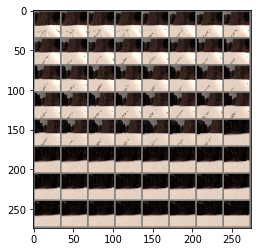

In [ ]:
try:
  images, labels = next(iter(test_loader))
except EOFError:
  pass

classes = ('0', '1', '2', '3',
           '4', '5', '6', '6', '7', '8')

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground truth:\n")

print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

In [ ]:
outputs = net(images.to(device))
print(outputs.size())

NameError: ignored

In [ ]:
_, predicted = torch.max(outputs, 1)

print("Predicted:\n")
imshow(torchvision.utils.make_grid(images))

print(' '.join('{:>10}'.format(classes[predicted[j]]) for j in range(test_batch_size)))